<a href="https://colab.research.google.com/github/nizar20172016/My-Projects/blob/master/andOrGate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.nn.parameter import Parameter

In [162]:
def gen_data(num_samples, noise=0):
  points = []
  labels = []

  for i in range(num_samples):
    x = np.random.uniform()
    y = np.random.uniform()
    
    nx = np.random.uniform(low=-noise/100, high=noise/100)
    ny = np.random.uniform(low=-noise/100, high=noise/100)

    if(-0.3*x-y +0.4 > 0 or -0.3*x-y +0.9 < 0 ):
        if noise > 0:
            points.append([x+nx, y+ny, 0])
            labels.append(0)
        else:
            points.append([x, y, 0])
            labels.append(0)
    elif(7.7*x-2.0 > 0 and 7.7*x-3.5<0 and -0.3*x-y +0.5 < 0 and -0.3*x-y +0.8 > 0  ):
        if noise > 0:
            points.append([x+nx, y+ny, 0])
            labels.append(0)
        else:
            points.append([x, y, 0])
            labels.append(0)
    else:
        if noise > 0:
            points.append([x+nx, y+ny, 1])
            labels.append(1)
        else:
            points.append([x, y, 1])
            labels.append(1)

  return points, labels

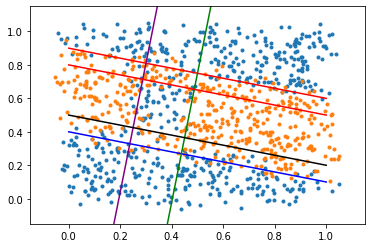

In [183]:
points, labels = gen_data(1000, 7)


plt.plot([i[0] for i in points if i[2] == 0], [i[1] for i in points if i[2] == 0], '.')
plt.plot([i[0] for i in points if i[2] == 1], [i[1] for i in points if i[2] == 1], '.')

# plot lines
x = torch.linspace(0,1)
plt.plot(x, (-0.3*x+0.4), 'blue')    # y = 0.9*x+0.1 => 0.9*x-y+0.1 < 0 
plt.plot(x, (-0.3*x+0.9), 'red')    # y = 0.9*x+0.1 => 0.9*x-y+0.1 < 0 
plt.plot(x, (7.7*x-3.1), 'green')    # y = 0.9*x+0.1 => 0.9*x-y+0.1 < 0 
plt.plot(x, (7.7*x-1.5), 'purple')    # y = 0.9*x+0.1 => 0.9*x-y+0.1 < 0 
plt.plot(x, (-0.3*x+0.5), 'black')    # y = 0.9*x+0.1 => 0.9*x-y+0.1 < 0 
plt.plot(x, (-0.3*x+0.8), 'red')    # y = 0.9*x+0.1 => 0.9*x-y+0.1 < 0 
plt.ylim(-0.15, 1.15)
plt.xlim(-0.15, 1.15)
plt.show()

In [164]:

class SquashingFunction(nn.Module):
    '''
    Shape:
        - Input: (N, *) where * means, any number of additional
          dimensions
        - Output: (N, *), same shape as the input
    Examples:
        m = squashing(beta=25)
        input = torch.randn(2)
        output = m(input)

        Input/Output have same shape:
        input.shape
        output.shape
    '''
    def __init__(self,learnable=True, beta=0.1):
        '''
        Init method.
        '''
        super(SquashingFunction, self).__init__()
        
        self.alpha = 0.5
        self.lam = 1.0
        
        if learnable:
            # initialize beta as learnable parameter
            self.beta = Parameter(torch.tensor(beta))
            self.beta.requiresGrad = True
        else:
            # static value
            self.beta = torch.tensor(beta)
            self.beta.requiresGrad = False
            
        self.beta.requiresGrad = True # set requiresGrad to true!

    def forward(self, x):
        '''
        Forward pass of the function.
        '''
        #print("Beta:", self.beta.data.item())
        # define beta global for pandas print
        global betas 
        betas = self.beta.data.item()
        return (1/(self.lam * self.beta)) * torch.log( (1+torch.exp(self.beta*(x-(self.alpha-(self.lam/2)))) ) / (1+torch.exp(self.beta*(x-(self.alpha+(self.lam/2))))) )

In [165]:
trainX = torch.Tensor([[i[0],i[1]] for i in points]).float()
trainY = torch.Tensor([[i[2]] for i in points]).float()

In [180]:
class SimpleNetwork(nn.Module):
    def __init__(self):
        super(SimpleNetwork, self).__init__()

        self.linear_layer_1 = nn.Linear(2, 1)
        self.linear_layer_2 = nn.Linear(2, 1)
        self.linear_layer_3 = nn.Linear(2, 1)
        self.linear_layer_4 = nn.Linear(2, 1)
        self.linear_layer_5 = nn.Linear(2, 1)
        self.linear_layer_6 = nn.Linear(2, 1)
        
        
        self.activation1 = SquashingFunction()


        #  Gates
       
        self.or_layer = nn.Linear(in_features=2, out_features=1)
        self.and_layer = nn.Linear(in_features=4, out_features=1)
        self.orOut_layer = nn.Linear(in_features=2, out_features=1)
        
        
        self.or_layer.weight.requires_grad = False
        self.or_layer.bias.requires_grad  = False

        self.and_layer.weight.requires_grad = False
        self.and_layer.bias.requires_grad  = False

        self.orOut_layer.weight.requires_grad = False
        self.orOut_layer.bias.requires_grad  = False
        
        with torch.no_grad():
            self.or_layer.weight.fill_(1.0)
            self.or_layer.bias.fill_(0.0)
            self.and_layer.bias.fill_(-3.0)
            self.and_layer.weight.fill_(1.0)
            self.orOut_layer.bias.fill_(0.0)
            self.orOut_layer.weight.fill_(1.0)
            
            
            



    def forward(self, X):
        self.z1 = self.linear_layer_1(X)
        self.z1 = self.activation1(self.z1)      # activation function

        self.z2 = self.linear_layer_2(X)
        self.z2 = self.activation1(self.z2)      # activation function
        
        self.z3 = self.linear_layer_3(X)
        self.z3 = self.activation1(self.z3)      # activation function

        self.z4 = self.linear_layer_4(X)
        self.z4 = self.activation1(self.z4)      # activation function
        
        self.z5 = self.linear_layer_5(X)
        self.z5 = self.activation1(self.z5)      # activation function

        self.z6 = self.linear_layer_6(X)
        self.z6 = self.activation1(self.z6)      # activation function
        global betaand
        global betagerade
        betagerade = betas
  
        
        
     

        self.or_ = self.or_layer(torch.cat((self.z1, self.z2), 1))
        self.or_ = self.activation1(self.or_)
        self.and_ = self.and_layer(torch.cat((self.z3,self.z4,self.z5,self.z6), 1))
        self.and_ = self.activation1(self.and_)
        self.or_out = self.orOut_layer(torch.cat((self.or_,self.and_), 1))
        self.or_out = self.activation1(self.or_out)
        betaand = betas

        
        return self.or_out


In [ ]:
learning_rate = 0.03
network = SimpleNetwork()
optimizer = optim.Adam(network.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

x = torch.linspace(-3, 3)

for epoch in range(10001):
    preds = network(trainX)
    #print(preds)
    loss = criterion(preds, trainY) # Calculate loss
    optimizer.zero_grad()
    loss.backward() # Calculate Gradient
    optimizer.step() # Update Weights
    if epoch %10 == 0:
        
      
        y1 = -((network.linear_layer_1.weight.squeeze()[0] * x + network.linear_layer_1.bias[0]) / network.linear_layer_1.weight.squeeze()[1])
        y2 = -((network.linear_layer_2.weight.squeeze()[0] * x + network.linear_layer_2.bias[0]) / network.linear_layer_2.weight.squeeze()[1])
        y3 = -((network.linear_layer_3.weight.squeeze()[0] * x + network.linear_layer_3.bias[0]) / network.linear_layer_3.weight.squeeze()[1])
        y4 = -((network.linear_layer_4.weight.squeeze()[0] * x + network.linear_layer_4.bias[0]) / network.linear_layer_4.weight.squeeze()[1])
        
        y5 = -((network.linear_layer_5.weight.squeeze()[0] * x + network.linear_layer_5.bias[0]) / network.linear_layer_5.weight.squeeze()[1])
        y6 = -((network.linear_layer_6.weight.squeeze()[0] * x + network.linear_layer_6.bias[0]) / network.linear_layer_6.weight.squeeze()[1])
        
    
        plt.plot([i[0] for i in points if i[2] == 0], [i[1] for i in points if i[2] == 0], '.')
        plt.plot([i[0] for i in points if i[2] == 1], [i[1] for i in points if i[2] == 1], '.')

        plt.plot(x.numpy(), y1.detach().numpy(), '-')
        plt.plot(x.numpy(), y2.detach().numpy(), '-')
        plt.plot(x.numpy(), y3.detach().numpy(), '-')
        plt.plot(x.numpy(), y4.detach().numpy(), '-')
        plt.plot(x.numpy(), y5.detach().numpy(), '-')
        plt.plot(x.numpy(), y6.detach().numpy(), '-')
        #print("Beta:", betas)
        print("Beta-Gerade:", betagerade)
        print("Beta-AND:", betaand)
        plt.ylim(0,1)
        plt.xlim(0,1)
        plt.title(f'Epoch: {epoch}; Learning Rate: {learning_rate}')
        plt.show()

1*0 + 1*0 = 0
1*1 + 1*0 = 1
1*0 + 1*1 = 1
1*1 + 1*1 = 2
